In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA

# Configuración estética
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [22]:
# Cargar el dataset
df = pd.read_csv("test_set_1.csv")

# Vista inicial
df.head()

,userId,movieId,rating,timestamp
0,66954,780,3.0,850944100
1,9877,566,3.0,945497442
2,38348,1086,4.0,999975049
3,177202,1020,4.0,948169041
4,140400,275079,3.5,1653782463


In [23]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333368 entries, 0 to 5333367
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 162.8 MB


In [24]:
# Estadísticas descriptivas
df.describe()

,userId,movieId,rating,timestamp
count,5.333368e+06,5.333368e+06,5.333368e+06,5.333368e+06
mean,1.003232e+05,2.932297e+04,3.540315e+00,1.275147e+09
std,5.795290e+04,5.096274e+04,1.059116e+00,2.561771e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,8.228736e+08
25%,5.014500e+04,1.232000e+03,3.000000e+00,1.050908e+09
50%,1.003430e+05,3.461000e+03,3.500000e+00,1.272265e+09
75%,1.505050e+05,4.419900e+04,4.000000e+00,1.503066e+09
max,2.009480e+05,2.927550e+05,5.000000e+00,1.697164e+09


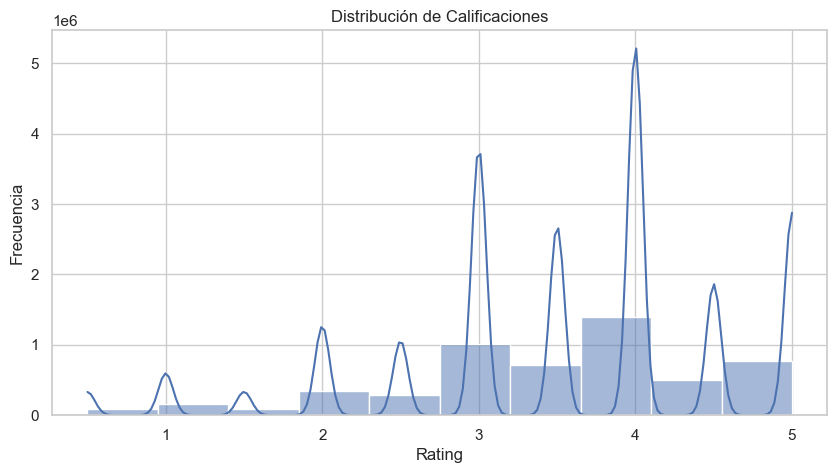

In [25]:
# Distribución de calificaciones
sns.histplot(df['rating'], bins=10, kde=True)
plt.title("Distribución de Calificaciones")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

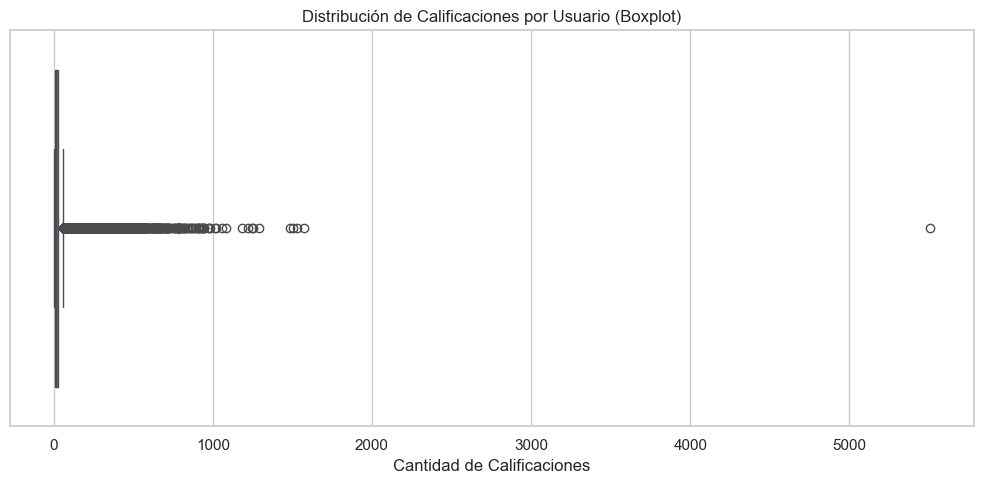

In [26]:
user_counts = df['userId'].value_counts()
sns.boxplot(x=user_counts)
plt.title("Distribución de Calificaciones por Usuario (Boxplot)")
plt.xlabel("Cantidad de Calificaciones")
plt.tight_layout()
plt.show()


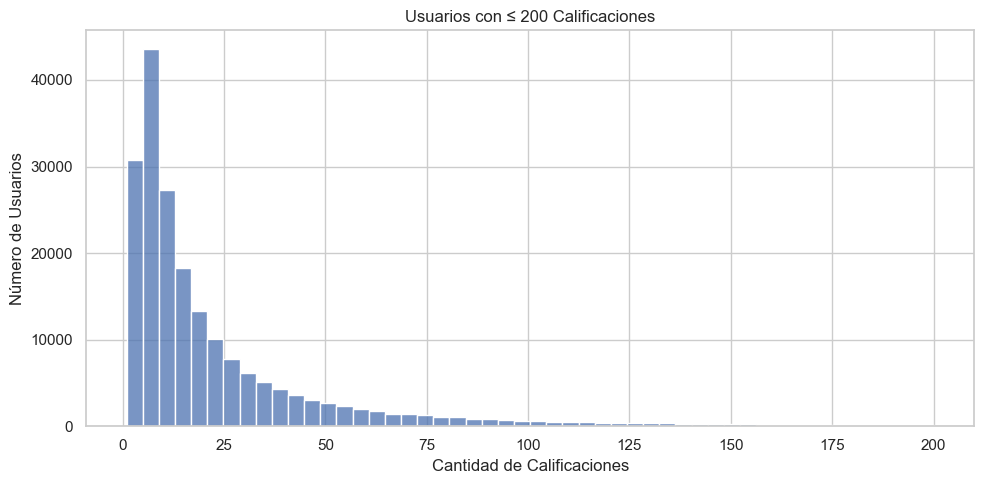

In [27]:
user_counts_trimmed = user_counts[user_counts <= 200]
sns.histplot(user_counts_trimmed, bins=50, kde=False)
plt.title("Usuarios con ≤ 200 Calificaciones")
plt.xlabel("Cantidad de Calificaciones")
plt.ylabel("Número de Usuarios")
plt.tight_layout()
plt.show()


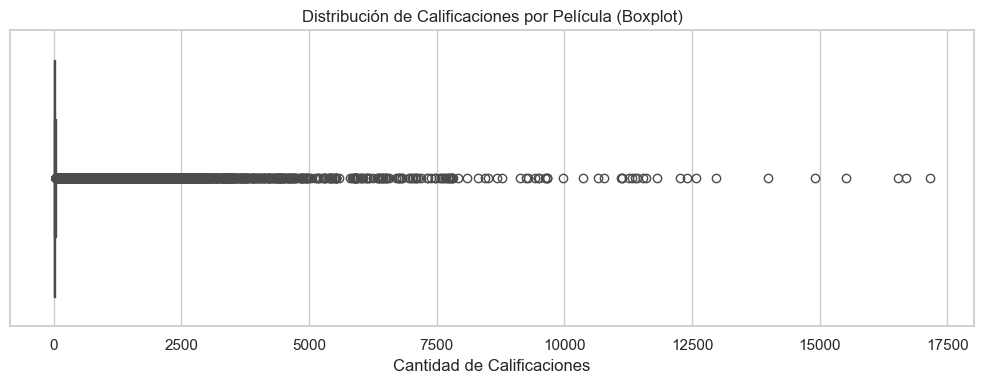

In [28]:
movie_counts = df['movieId'].value_counts()
plt.figure(figsize=(10, 4))
sns.boxplot(x=movie_counts)
plt.title("Distribución de Calificaciones por Película (Boxplot)")
plt.xlabel("Cantidad de Calificaciones")
plt.tight_layout()
plt.show()

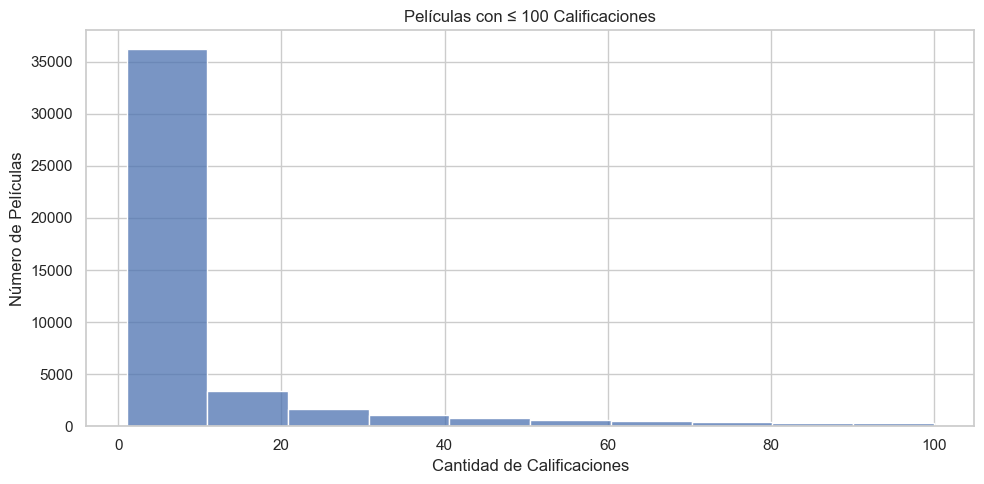

In [29]:
movie_counts_trimmed = movie_counts[movie_counts <= 100]

plt.figure(figsize=(10, 5))
sns.histplot(movie_counts_trimmed, bins=10, kde=False)
plt.title("Películas con ≤ 100 Calificaciones")
plt.xlabel("Cantidad de Calificaciones")
plt.ylabel("Número de Películas")
plt.tight_layout()
plt.show()

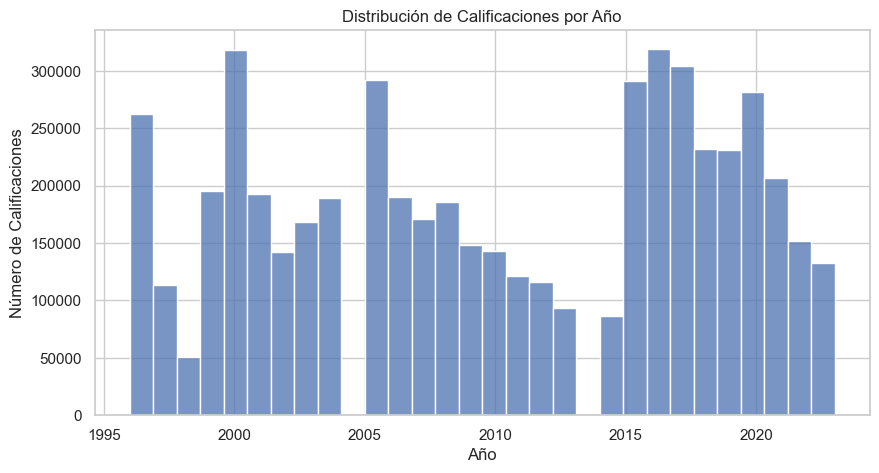

In [30]:
# Conversión de timestamp a fecha
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['date'].dt.year

# Evolución de calificaciones por año
sns.histplot(df['year'], bins=30, kde=False)
plt.title("Distribución de Calificaciones por Año")
plt.xlabel("Año")
plt.ylabel("Número de Calificaciones")
plt.show()

# Experimentos

In [31]:
# Generar variables temporales en base a timestamp
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

df

,userId,movieId,rating,timestamp,date,year,month,weekday
0,66954,780,3.0,850944100,1996-12-18 21:21:40,1996,12,2
1,9877,566,3.0,945497442,1999-12-18 06:10:42,1999,12,5
2,38348,1086,4.0,999975049,2001-09-08 18:50:49,2001,9,5
3,177202,1020,4.0,948169041,2000-01-18 04:17:21,2000,1,1
4,140400,275079,3.5,1653782463,2022-05-29 00:01:03,2022,5,6
...,...,...,...,...,...,...,...,...
5333363,58503,8961,4.0,1114211827,2005-04-22 23:17:07,2005,4,4
5333364,75529,2278,4.0,986630941,2001-04-07 08:09:01,2001,4,5
5333365,3245,36519,3.5,1312491655,2011-08-04 21:00:55,2011,8,3
5333366,49658,5690,5.0,1233266334,2009-01-29 21:58:54,2009,1,3


In [32]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'invierno'
    elif month in [3, 4, 5]:
        return 'primavera'
    elif month in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'
    
df['season'] = df['month'].apply(get_season)
df

,userId,movieId,rating,timestamp,date,year,month,weekday,season
0,66954,780,3.0,850944100,1996-12-18 21:21:40,1996,12,2,invierno
1,9877,566,3.0,945497442,1999-12-18 06:10:42,1999,12,5,invierno
2,38348,1086,4.0,999975049,2001-09-08 18:50:49,2001,9,5,otoño
3,177202,1020,4.0,948169041,2000-01-18 04:17:21,2000,1,1,invierno
4,140400,275079,3.5,1653782463,2022-05-29 00:01:03,2022,5,6,primavera
...,...,...,...,...,...,...,...,...,...
5333363,58503,8961,4.0,1114211827,2005-04-22 23:17:07,2005,4,4,primavera
5333364,75529,2278,4.0,986630941,2001-04-07 08:09:01,2001,4,5,primavera
5333365,3245,36519,3.5,1312491655,2011-08-04 21:00:55,2011,8,3,verano
5333366,49658,5690,5.0,1233266334,2009-01-29 21:58:54,2009,1,3,invierno


In [33]:
df['is_weekend'] = df['weekday'].isin([5, 6])
df

,userId,movieId,rating,timestamp,date,year,month,weekday,season,is_weekend
0,66954,780,3.0,850944100,1996-12-18 21:21:40,1996,12,2,invierno,False
1,9877,566,3.0,945497442,1999-12-18 06:10:42,1999,12,5,invierno,True
2,38348,1086,4.0,999975049,2001-09-08 18:50:49,2001,9,5,otoño,True
3,177202,1020,4.0,948169041,2000-01-18 04:17:21,2000,1,1,invierno,False
4,140400,275079,3.5,1653782463,2022-05-29 00:01:03,2022,5,6,primavera,True
...,...,...,...,...,...,...,...,...,...,...
5333363,58503,8961,4.0,1114211827,2005-04-22 23:17:07,2005,4,4,primavera,False
5333364,75529,2278,4.0,986630941,2001-04-07 08:09:01,2001,4,5,primavera,True
5333365,3245,36519,3.5,1312491655,2011-08-04 21:00:55,2011,8,3,verano,False
5333366,49658,5690,5.0,1233266334,2009-01-29 21:58:54,2009,1,3,invierno,False


In [34]:
ecu_holidays = holidays.Ecuador(years=range(df['date'].dt.year.min(), df['date'].dt.year.max() + 1))
df['is_holiday'] = df['date'].isin(ecu_holidays)
print(df[['season', 'is_weekend', 'is_holiday']].describe(include='all'))

C:\Users\s3_xc\AppData\Local\Temp\ipykernel_11796\2658432674.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['date'].isin(ecu_holidays)


          season is_weekend is_holiday
count    5333368    5333368    5333368
unique         4          2          2
top     invierno      False      False
freq     1360697    3737820    5333366


In [35]:
df['rating_previous'] = df.groupby('userId')['rating'].shift()
df['rating_previous'].fillna(0, inplace=True)

C:\Users\s3_xc\AppData\Local\Temp\ipykernel_11796\2917305912.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating_previous'].fillna(0, inplace=True)


In [36]:
# 🔹 1. Codificación de variables categóricas/booleanas
df['season_encoded'] = df['season'].map({'invierno': 0, 'primavera': 1, 'verano': 2, 'otoño': 3})
df['is_weekend'] = df['is_weekend'].astype(int)
df['is_holiday'] = df['is_holiday'].astype(int)


In [37]:
# 🔹 2. Selección de features temporales para UMAP
temporal_features = ['year', 'month', 'weekday', 'season_encoded', 'is_weekend', 'is_holiday', 'rating_previous']

In [38]:
# Normalizar
features = ['year', 'month', 'weekday', 'season_encoded', 'is_weekend', 'is_holiday', 'rating_previous']
X_scaled = StandardScaler().fit_transform(df[features])

In [39]:
# ⚠️ Muestra aleatoria para entrenamiento de UMAP
sample_size = 100_000  # ajustable según tu RAM
sample_idx = np.random.choice(len(X_scaled), size=sample_size, replace=False)
X_sample = X_scaled[sample_idx]


In [40]:
# Entrenar UMAP sobre el subset
reducer = umap.UMAP(n_components=3, random_state=42, init='random', n_neighbors=15, min_dist=0.1)
reducer.fit(X_sample)

c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(init='random', n_components=3, n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [41]:
X_umap_full = reducer.transform(X_scaled)

# Insertar en el DataFrame
df[['temporal_1', 'temporal_2', 'temporal_3']] = X_umap_full


In [44]:
columns_to_keep = ['userId', 'movieId', 'temporal_1', 'temporal_2', 'temporal_3', 'rating']
df_rnn_ready = df[columns_to_keep]

# Guardar dataset limpio para la RNN
df_rnn_ready.to_csv("dataset_rnn_ready.csv", index=False)
